# Chasing the Game 2

## Examining passing patterns and the impact of scoreline in Soccer

As a continuation of our analysis into the impact of "chasing the game", we now undertake an analysis of the impact of scoreline on the spatial distribution of passes. As described in the previous notebook, when a team is losing in soccer they will typically play more aggressively to increase their chances of scoring, while also increasing their chances of conceding. The leading team will have incentive to play more defensively, or at the very least more conservatively (e.g. by keeping possession), which will decrease their chances of scoring and of conceding.

In the first notebook, we analyzed the impact of the scoreline on scoring rates of the two teams. In this notebook we are looking to produce a visiual represenation of the competing strategies of the trailing and leading teams by analyzing their patterns of passing.

We will first consider the impact of leading/trailing on pass type and length for each team. Following this we will then analyze the impact on spatial distribution of where passes are targetted by teams in the two different scenarios. More specifically, we look at the difference in spatial distribution of where passes are taken/targetted for the leading and trailing teams relative to the corresponding distribution in tied games (hereafter we will refer to this as the base distribution). We then expand our analysis to consider vector field approaches to modelling the passing structure of teams. We use this framework to further analyze the impact of trailing or leading in a game.

The data used for this analysis, as well as some data importing code, were accessed from:

* Pappalardo, Luca; Massucco, Emanuele (2019): Soccer match event dataset. figshare. Collection. https://doi.org/10.6084/m9.figshare.c.4415000

* Pappalardo, L., Cintia, P., Rossi, A. et al. A public data set of spatio-temporal match events in soccer competitions. Sci Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7

## Importing packages

In [1]:
import json
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Ellipse
from IPython.display import clear_output
import seaborn as sns
sns.set_theme()
from sklearn.neighbors import KernelDensity
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings('ignore')

## Data setup

The code below loads in the events and matches data and then identifies passes and pulls them into a dataframe. Due to the significant volume of pass observations, we focused exclusively on the English Premier League to manage computation time for the analysis. The following code is nonetheless setup to facilitate adding in the remaining European domestic leagues if desired.

In [2]:
events={}
nations = ['England']
for nation in nations:
    with open('events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)

matches={}
nations = ['England']
for nation in nations:
    with open('matches/matches_%s.json' %nation) as json_data:
        matches[nation] = json.load(json_data)

In [3]:
event_name = 'Pass'
event_tag = [1801,1802]
pass_time = []

for nation in nations:
    for ev in events[nation]:
        if ev['eventName'] == event_name:
            for i in range(len(ev['tags'])):
                if ev['tags'][i]['id'] in event_tag:
                    pass_time.append([ev['matchId'],ev['matchPeriod'],ev['eventSec'],ev['id'],ev['teamId'],nation,ev['subEventId'],
                                      ev['tags'][i]['id'],ev['positions'][0]['x'],100-ev['positions'][0]['y'],ev['positions'][1]['x'],
                                      100-ev['positions'][1]['y']])
                else:
                    pass

df_passes = pd.DataFrame(pass_time, columns=['matchId','matchPeriod','eventSec','id','teamId','nation','eventId','tag','start_x','start_y','end_x','end_y'])

print('Number of passes observed: {:.0f}'.format(len(df_passes)))

Number of passes observed: 328657


#### Identifying home and away teams

As will be shown later, our scoreline information is presented in a home-away format. Therefore we need to know which team is home/away to identify which of the teams is in a losing or winning position at the time an observed pass is executed.

The information around which team is home or away is identified from the matches data we imported earlier. As we have a large dataset of passes, we structured the code below to utilize the merge functionality of Pandas to get this information for each of the passes as this saves significant computation time. Firstly the home/away teamIds are identified for each matchId, and then a join is done based on matchId and teamId to identify the home/away status of the team performing each pass in our dataset.

In [4]:
match_data = []

for nation in nations:
    for ma in matches[nation]:
        team_1 = list(ma['teamsData'].keys())[0]
        team_2 = list(ma['teamsData'].keys())[1]
        match_data.append([ma['wyId'],int(team_1),ma['teamsData'][team_1]['side'],nation])
        match_data.append([ma['wyId'],int(team_2),ma['teamsData'][team_2]['side'],nation])
        
df_match = pd.DataFrame(match_data, columns=['matchId','teamId','homeaway','nation'])

df_passes = df_passes.merge(df_match.drop(['nation'],axis=1), how='left', on=['matchId', 'teamId'])

#### Scoreline data

We now import the scoreline data, which is just a CSV of the df_goals data from the first notebook in this series. We also add halfIds to the pass data, which is just the matchId with the half number appended, producing unique halfIds for each half. This step is taken as the goal times restart at 0 in each half, so we analyze each half individually for convenience. Ultimately this will have no impact on the pass data.

In [5]:
df_scores = pd.read_csv('scoreline_data.csv',index_col=0)

df_passes['halfId'] = df_passes['matchId'].astype(str)+df_passes['matchPeriod']

We next need to apply the scoreline from the scoreline data to each pass event in our data. Thankfully, we can do this by utilizing an "as of" merge. This is done on a "backwards" direction, which identifies the most recent scoreline for each pass within each halfId. 

In [6]:
df_passes = pd.merge_asof(df_passes.sort_values('eventSec',ascending=True), 
                          df_scores.sort_values('eventSec',ascending=True)[['halfId','eventSec','score']],
                          on='eventSec', by='halfId')

df_passes = df_passes.sort_values(by=['halfId','eventSec'])

df_passes = df_passes.reset_index().drop(['index'],axis=1)

After adding in the scoreline data, we found we have a few matches missing. However there are only 6 missing, so we will drop the data for these matches and proceed with the analysis.

In [7]:
print('Number of missing games:',len(df_passes.loc[df_passes['score'].isna()]['matchId'].unique()))

df_passes = df_passes.dropna(axis=0)

Number of missing games: 6


#### Splitting pass data

As discussed, we want to look into the impact of trailing or leading on the passing patterns of teams. Therefore, we break the passes into different groups based on whether the team making the pass is tied, trailing, or leading. We have stuck to scorelines only up to 2 goals per team as including more dominant scorelines will introduce more confounding from the leading team being the clearly superior team.

In [8]:
df_passes_base = df_passes.loc[(df_passes['score'].isin(['0-0','1-1','2-2']))]
df_passes_base['status'] = 'tied'

df_passes_trailing = df_passes.loc[((df_passes['homeaway']=='home') & (df_passes['score'].isin(['0-1','0-2','1-2']))) |
                                    ((df_passes['homeaway']=='away') & (df_passes['score'].isin(['1-0','2-0','2-1'])))]
df_passes_trailing['status'] = 'trailing'

df_passes_leading = df_passes.loc[((df_passes['homeaway']=='away') & (df_passes['score'].isin(['0-1','0-2','1-2']))) |
                                   ((df_passes['homeaway']=='home') & (df_passes['score'].isin(['1-0','2-0','2-1'])))]
df_passes_leading['status'] = 'leading'

## Analysis

#### Pass distance

The first analysis we perform is a simple examination of the distribution of pass length for teams in each scenario (i.e., trailing, tied, or leading). We estimate the distributions using a kernel density estimator (KDE). We first define a KDE function and then apply it to the three pass datasets and plot below. For this analysis, we convert the 100x100 coordinates into equivalent 104x68 coordinates to get a better representation of the actual length of the passes being taken in meters.

In [9]:
def kde_passes(df, bandwidth, pass_space):
    pass_lengths = ((((df['start_x']-df['end_x'])*(104/100))**2+((df['start_y']-df['end_y'])*(68/100))**2)**0.5).to_numpy().reshape(-1,1)
    
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(pass_lengths)
    log_kde = kde.score_samples(pass_space)
    
    return log_kde

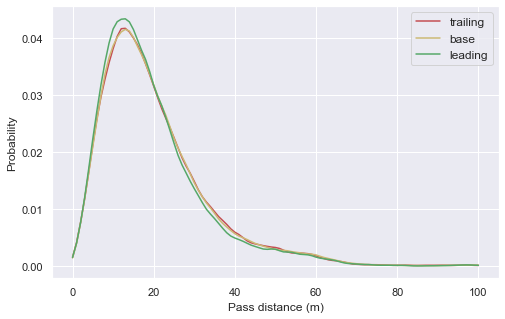

In [10]:
pass_space = np.linspace(0,100,101).reshape(-1,1)
bandwidth = 1.0

args = [bandwidth,pass_space]

kde_base = kde_passes(df_passes_base, *args)
kde_trailing = kde_passes(df_passes_trailing, *args)
kde_leading = kde_passes(df_passes_leading, *args)

fig, ax = plt.subplots(figsize=(8,5))

plt.plot(np.exp(kde_trailing),label='trailing', color='r')
plt.plot(np.exp(kde_base),label='base', color='y')
plt.plot(np.exp(kde_leading),label='leading', color='g')
plt.legend(fontsize='medium')
plt.xlabel('Pass distance (m)')
plt.ylabel('Probability')

plt.show()

As shown above, the trailing and tied pass lengths are very similar, while leading teams take generally shorter passes. This is likely representative of leading teams keeping possession and playing more conservatively with shorter range passes.

#### Pass type

We now shift our analysis to look at the impact of trailing or leading the game on the choice of different types of passes. Specifically, we have looked at short passes, long passes, and crosses. We felt these pass types were the most relevant to analyzing the changes in teams' playstyles based on scoreline. The code below can be adjusted to include other pass types as well.

The code below first groups the data and then the following cell produces the relevant plots.

In [11]:
df_passes_grouped = pd.concat([df_passes_base,df_passes_trailing,df_passes_leading])
data = df_passes_grouped.groupby(['status','eventId']).count()['matchId']
data_pcts = data.groupby(level=0).apply(lambda x: 100 * x / int(x.sum()))
data_pcts = data_pcts.unstack().T
data_pcts = data_pcts[['trailing','tied','leading']]

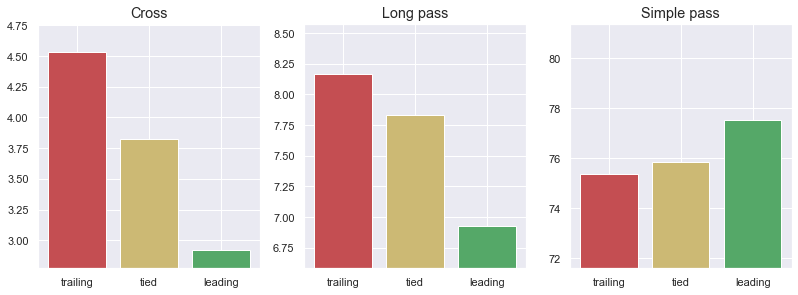

In [12]:
pass_dict = {80:'Cross',
             81:'Hand pass',
             82:'Head pass',
             83:'Long pass',
             84:'Launch',
             85:'Simple pass',
             86:'Smart/incisive pass'}

# Selecting which pass types to include

pass_types = [80,83,85]

fig, ax = plt.subplots(1,len(pass_types),figsize=(4.5*len(pass_types),4.5))

buffer = 0.05

for j, i in enumerate(pass_types):
    ax[j].bar(data_pcts.loc[i].index,height=data_pcts.loc[i], color=['r','y','g'])
    ax[j].set_ylim(np.min(data_pcts.loc[i])*(1-buffer),np.max(data_pcts.loc[i])*(1+buffer))
    ax[j].set_title(pass_dict[i], size='large')

The units above represent the percentage of pass-type selection in each scenario. We see that trailing teams will utilize crosses and long passes (passes with a higher 'variance' in outcomes), while the leading team will select these passes less often. Short passes follow an opposite pattern, with leading teams using short passes significantly more, likely to maintain possession and take less risk. These patterns are consistent with our expectations going into this analysis.

## Spatial analysis

We next move on to the spatial analysis discussed earlier in the notebook.

Below we define the pitch plotting function we will use as a backdrop for the plots, this was initially adapted from Pappalardo et al. (2019), with significant modifications to help facilitate our analysis/comparisons.

In [13]:
def pitch(ax, color='black', grass=False, axis=True, arrow=True):

    #Pitch Outline & Centre Line
    ax.plot([0,0],[0,100], color=color)
    ax.plot([0,100],[100,100], color=color)
    ax.plot([100,100],[100,0], color=color)
    ax.plot([100,0],[0,0], color=color)
    ax.plot([50,50],[0,100], color=color)

    #Left Penalty Area
    ax.plot([16.5,16.5],[80,20],color=color)
    ax.plot([0,16.5],[80,80],color=color)
    ax.plot([16.5,0],[20,20],color=color)

    #Right Penalty Area
    ax.plot([83.5,100],[80,80],color=color)
    ax.plot([83.5,83.5],[80,20],color=color)
    ax.plot([83.5,100],[20,20],color=color)

    #Left 6-yard Box
    ax.plot([0,5.5],[65,65],color=color)
    ax.plot([5.5,5.5],[65,35],color=color)
    ax.plot([5.5,0.5],[35,35],color=color)

    #Right 6-yard Box
    ax.plot([100,94.5],[65,65],color=color)
    ax.plot([94.5,94.5],[65,35],color=color)
    ax.plot([94.5,100],[35,35],color=color)

    #Prepare Circles
    centreCircle = Ellipse((50, 50), width=30, height=39, edgecolor=color, facecolor="None", lw=1.8)
    centreSpot = Ellipse((50, 50), width=1, height=1.5, edgecolor=color, facecolor=color, lw=1.8)
    leftPenSpot = Ellipse((11, 50), width=1, height=1.5, edgecolor=color, facecolor=color, lw=1.8)
    rightPenSpot = Ellipse((89, 50), width=1, height=1.5, edgecolor=color, facecolor=color, lw=1.8)

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)
    
    #limit axis
    ax.set_xlim(0,100)
    ax.set_ylim(0,100)
    
    img = plt.imread("pitch.png")
    
    #Add grass background
    if grass == True:
        ax.imshow(img, aspect='auto', extent =[0,100,0,100])
    
    #Turn off axis
    if axis == False:
        ax.axis('off')
    
    #Add attacking arrow indication
    if arrow == True:
        ax.annotate("", xy=(25, 5), xytext=(5, 5),
                    arrowprops=dict(arrowstyle="->", linewidth=1, color='black'))
        
    return fig,ax

#### Density of passing events

Below we set up a KDE function to apply to our passing data, as well as a grid on which to evaluate the resulting densities. We set the function up to consider either the starting or ending locations of passes. In our case we will be focusing specifically on the ending locations of passes to understand the areas where teams are targeting their passes in each scenario.

Additionally, we add a sample_n parameter to randomly sample a specified number of observations from the given data. This step helps to manage computation time.

In [14]:
# Setting up a grid on which to evaluate KDEs

X, Y = np.mgrid[0:100:101j,0:100:101j]
xy = np.vstack((X.flatten(), Y.flatten())).T

# Defining the KDE evaluation function

def kde_fit(df, bandwidth, sample_n, pass_types, start_end, random_state):
    if start_end == 'start':
        i = 'start_x'
        j = 'start_y'
    elif start_end == 'end':
        i = 'end_x'
        j = 'end_y'
    else:
        return "Please select start or end of passes"
    
    x_y = df.loc[df['eventId'].isin(pass_types)][[i,j]].sample(sample_n,random_state=random_state).astype(float)
    
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(np.vstack([x_y[i],x_y[j]]).T)
    log_kde = kde.score_samples(xy)
    
    Z = np.exp(log_kde)
    Z = Z.reshape(X.shape)
    
    return Z

Below we do a preliminary KDE analysis of the base scenario (i.e. tied scoreline) passing data using our newly defined function. We limit the analysis to only short passes and long passes, which captures a significant majority of the data. We set the bandwidth relatively wide in order to capture a smooth representation of the structure in the data.

In [15]:
sample_n = 20000
bandwidth = 10
pass_types = [83,85]
seed = 1
segment = 'end'

args = [bandwidth, sample_n, pass_types, segment, seed]

Z_base = kde_fit(df_passes_base, *args)

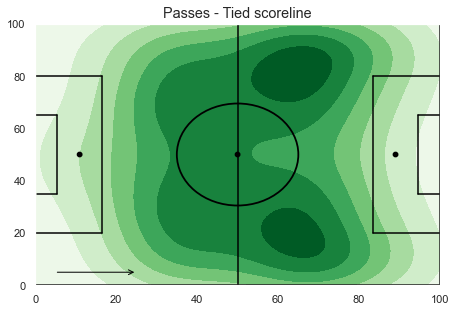

In [16]:
fig, ax = plt.subplots(figsize=(6.5,4.5))
pitch(ax,'black', grass=False)

ax.contourf(X,Y,Z_base, cmap='Greens')
ax.set_title('Passes - Tied scoreline', size='large')

plt.tight_layout()
plt.show()

#### Comparing pass distributions

We now compare the pass distributions under different scorelines. We first look at the difference in pass distribution between teams in a trailing position and the baseline distribution when the game is tied. Secondly, we look at the same difference between teams in a leading position and the same baseline distribution.

Below we first calculate the relevant densities in each of the three scenarios and calculate the relevant differences.

In [17]:
sample_n = 20000
bandwidth = 10
pass_types = [83,85]
seed = 1
segment = 'end'

args = [bandwidth, sample_n, pass_types, segment, seed]

Z_base = kde_fit(df_passes_base, *args)
Z_trailing = kde_fit(df_passes_trailing, *args)
Z_leading = kde_fit(df_passes_leading, *args)

Z_trailing_change = (Z_trailing-Z_base)
Z_leading_change = (Z_leading-Z_base)

We plot the respective differences for trailing and leading teams below. We have normalized the color scale consistently acorss the two plots with red showing areas with an increased number of passes, and blue representing areas with decreased passes.

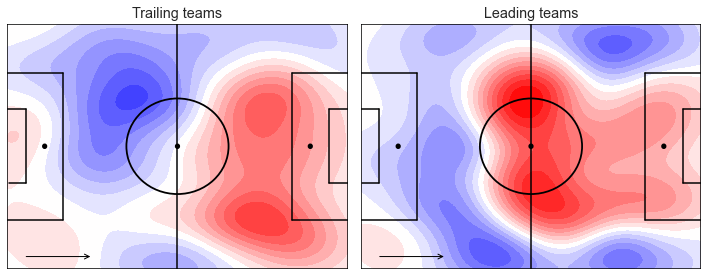

In [18]:
vmin = -np.abs([Z_trailing_change,Z_leading_change]).max()
vmax = np.abs([Z_trailing_change,Z_leading_change]).max()

levels = np.linspace(vmin,vmax,20)

fig, ax = plt.subplots(1,2,figsize=(10,4))
pitch(ax[0], 'black', axis=False)
pitch(ax[1], 'black', axis=False)

offset = mcolors.Normalize(vmin=vmin, vmax=vmax)

ax[0].contourf(X,Y,Z_trailing_change, levels=levels, cmap='bwr', norm=offset)
ax[0].set_title('Trailing teams', size='large')

ax[1].contourf(X,Y,Z_leading_change, levels=levels, cmap='bwr', norm=offset)
ax[1].set_title('Leading teams', size='large')

plt.tight_layout()
plt.show()

As shown above, teams in a trailing position will target passes further forward relative to the base distribution. This is consistent with our expectations that the trailing team will play more directly and aggressively.

Conversely, the leading team targets a significantly higher number of passes towards the middle of the pitch. Additionally, there is also a slight increase in passes towards the opponent's box, which may be representative of counter attacking opporunities resulting from the trailing team's more aggressive play. This may also be starting to capture some of the confounding discussed in the previous notebook (i.e. teams leading generally are the better team). Lastly, a very prominent pattern is that the leading team will pass to the sideline/corner areas in the opponent's half much less. These are areas where the team may have a higher risk of losing possession.

#### Vector field analysis

In order to investigate the above observations further, we take another approach to analyzing the passing patterns of the trailing and leading teams. Here we now look at an estimated vector field for pass length/direction in each segment of the field. The motivation here is to provide a more fullsome understanding of how teams are moving the ball around the field.

To proceed with our analysis, we first define a function to identify this information based on a grid segmentation of the field.

In [19]:
def vector_field(df, n, pass_types):
    space = np.linspace(0,100,n)
    x_vectors = np.ndarray([n-1,n-1])
    y_vectors = np.ndarray([n-1,n-1])
    
    for i in range(1,n):
        for j in range(1,n):
            passes = df.loc[(df['start_x'] > space[i-1]) & (df['start_x'] < space[i]) & (df['start_y'] > space[j-1]) & (df['start_y'] < space[j]) & (df['eventId'].isin(pass_types))]
            mean_x = (passes['end_x']-passes['start_x']).mean()
            mean_y = (passes['end_y']-passes['start_y']).mean()
            x_vectors[i-1,j-1] = mean_x
            y_vectors[i-1,j-1] = mean_y
    
    grid = space[1:]-(100/(2*(n-1)))
    return x_vectors.T, y_vectors.T, grid

Below we plot the vector fields for teams trailing and leading. We have specifically focused on short and long passes. This step is taken as we want to focus on how the team moves the ball around in possession. Non-possession oriented passes, such as crosses, will skew these results.

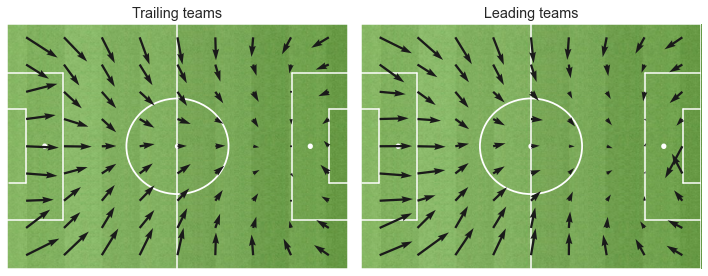

In [20]:
pass_types=[83,85]
n=10

x_vec1, y_vec1, grid1 = vector_field(df_passes_trailing,n=n,pass_types=pass_types)
x_vec2, y_vec2, grid2 = vector_field(df_passes_leading,n=n,pass_types=pass_types)

fig, ax = plt.subplots(1,2,figsize=(10,4))

pitch(ax[0],'white', grass=True, axis=False, arrow=False)
pitch(ax[1],'white', grass=True, axis=False, arrow=False)

ax[0].quiver(grid1, grid1, x_vec1, y_vec1, color='k', zorder=100)
ax[0].set_title('Trailing teams', size='large')

ax[1].quiver(grid2, grid2, x_vec2, y_vec2, color='k', zorder=100)
ax[1].set_title('Leading teams', size='large')

plt.tight_layout()
plt.show()

The two results generally follow a similar pattern corresponding to the typical ball movement of a soccer team. A close inspection will reveal some structural differences between the two figures. In order to better capture these structural differences, we now take the difference of the vector fields in each case relative to that in the base (i.e. tied) scenario.

In order to give a more representative result, we move to a more coarse field grid when taking the difference. This step is taken as under a higher resolution the variance of the individual vectors increases and the resulting noise crowds out the structural changes we want to observe.

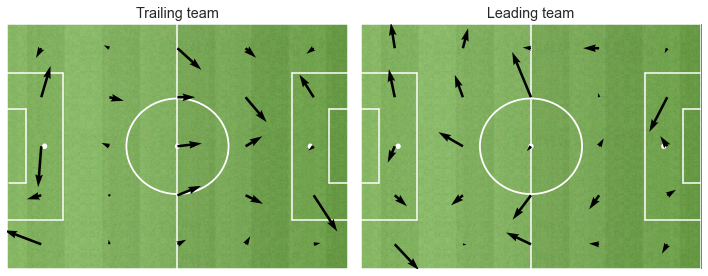

In [21]:
pass_types=[83,85]
n=6

args=[n,pass_types]

fig, ax = plt.subplots(1,2,figsize=(10,4))
pitch(ax[0],'white', grass=True, axis=False, arrow=False)
pitch(ax[1],'white', grass=True, axis=False, arrow=False)

x_vec1, y_vec1, grid1 = vector_field(df_passes_trailing, *args)
x_vec2, y_vec2, grid2 = vector_field(df_passes_base, *args)
x_vec3, y_vec3, grid3 = vector_field(df_passes_leading, *args)

ax[0].quiver(grid1, grid1, x_vec1-x_vec2, y_vec1-y_vec2, color='black', zorder=100)
ax[0].set_title('Trailing team', size='large')

ax[1].quiver(grid3,grid3,x_vec3-x_vec2,y_vec3-y_vec2, color='black', zorder=100)
ax[1].set_title('Leading team', size='large')

plt.tight_layout()
plt.show()

In the trailing team case shown above, we see significantly more central and forward passing directions in the midfield, particularly in the opponent's half. This result is consistent with our expectations of how teams chasing the game will play. In the leading team case, we see a much more conservative change to the passing vector field with significantly more backwards passing relative to the base scenario.

Before we jump into the next section we define a couple customized colormaps that we will use later.

In [22]:
cdict =  {'red': ((0.0, 0.0, 0.0),
                 (1.0, 0.0, 0.0)),
    
          'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
          
          'blue': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
          
          'black': ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),
         
          'alpha': ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0))
         }

cdict2 =  {'red': ((0.0, 0.0, 0.0),
                 (0.5, 0.0, 0.0),
                 (1.0, 0.75, 0.75)),
    
          'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
          
          'blue': ((0.0, 0.5, 0.5),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
         
          'alpha': ((0.0, 1.0, 1.0),
                    (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0))
         }

plt.register_cmap(name='Fade', data=cdict)
plt.register_cmap(name='RdBuFade', data=cdict2)

#### "Radial" vector analysis

We now expand this vector field analysis to consider "radial" vector fields, as described below. I am not sure if there's a well-defined term for this analysis, which is described further below. This analysis is in part inspired by Soccermatics, one of my all time favorite books.

We split passes in each zone into 12 groups based on the direction the pass is taken. Therefore, each group covers a 30 degree arc of possible pass directions. A demonstration of how the passes are grouped is presented in the graph below. The slopes of the lines are calculated to achieve the 30 degree angles and were identified with some basic trigonometry.

We also show an example of what the "radial" vectors coming from a single region of the field will look like with some generated data. The lengths/direction of the arrows are representative of the average length and direction of passes in each 30 degree arc. The opacity of the arrows represents the probability of a pass going in each of the directions, with more solid arrows representing a more common pass direction. In order to not overcrowd the diagram, the arrow heads have been narrowed.

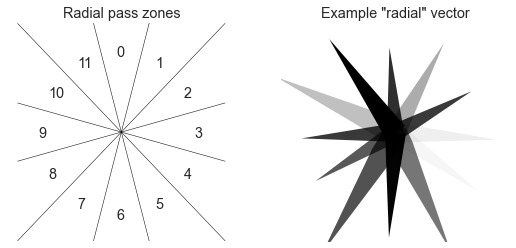

In [23]:
# Creating plot to show the radial passing zones.

grid = np.linspace(-10,10,50)
fig,ax = plt.subplots(1,2, figsize=(9,4))

args = {'color':'black',
        'linewidth':0.5}

slopes = [2+3**0.5, 1, 2-3**0.5]

for i in range(3):
    ax[0].plot(grid, slopes[i]*grid, **args)
    ax[0].plot(grid, -slopes[i]*grid, **args)

angles = [(i/6)*np.pi for i in range(12)]
label_x = np.sin(angles)*7.5-0.5
label_y = np.cos(angles)*7.5-0.5

for i in range(12):
    ax[0].annotate(i, xy=(label_x[i], label_y[i]), size='large')

ax[0].set_ylim(-10,10)
ax[0].set_title('Radial pass zones', size='large')
ax[0].axis('off')

# Creating fake data and demonstrating structure of a "radial pass vector"

scaler = np.random.uniform(0.4,0.6,12)
proportions = np.random.uniform(0.0,1.0,12)
proportions /= proportions.sum()

offset = mcolors.Normalize(vmin=0, vmax=proportions.max())

for i in range(12):
    ax[1].quiver(0, 0, label_x[i]*scaler[i], label_y[i]*scaler[i], proportions[i], cmap='Fade', norm=offset, width=0.1, headwidth=1.0, zorder=100, scale=8)
ax[1].set_title('Example "radial" vector', size='large')
ax[1].axis('off')

plt.show()

We now define a radial vector field function that will calculate these results over a grid of the field for a given dataframe of passes.

In [24]:
def radial_vector_field(df, n, pass_types):
    space = np.linspace(0,100,n)
    x_vectors = np.ndarray([n-1,n-1,12])
    y_vectors = np.ndarray([n-1,n-1,12])
    counts = np.ndarray([n-1,n-1,12])
    pcts = np.ndarray([n-1,n-1,12])
                                                                                                                            
    for i in range(1,n):
        for j in range(1,n):
            passes = df.loc[(df['start_x'] > space[i-1]) & (df['start_x'] < space[i]) & (df['start_y'] > space[j-1]) & (df['start_y'] < space[j]) & (df['eventId'].isin(pass_types))]
            
            # Pass zone 0
            passes_dir = passes.loc[(passes['end_y']-passes['start_y'] > (2+3**0.5)*np.abs(passes['end_x']-passes['start_x']))]
            
            x_vectors[i-1,j-1,0] = (passes_dir['end_x']-passes_dir['start_x']).mean()
            y_vectors[i-1,j-1,0] = (passes_dir['end_y']-passes_dir['start_y']).mean()
            counts[i-1,j-1,0] = len(passes_dir)
            
            # Pass zone 1
            passes_dir = passes.loc[(passes['end_y']-passes['start_y'] < (2+3**0.5)*(passes['end_x']-passes['start_x'])) &
                                  (passes['end_y']-passes['start_y'] > 1*(passes['end_x']-passes['start_x']))]
                                  
            x_vectors[i-1,j-1,1] = (passes_dir['end_x']-passes_dir['start_x']).mean()
            y_vectors[i-1,j-1,1] = (passes_dir['end_y']-passes_dir['start_y']).mean()
            counts[i-1,j-1,1] = len(passes_dir)
            
            # Pass zone 2
            passes_dir = passes.loc[(passes['end_y']-passes['start_y'] < 1*(passes['end_x']-passes['start_x'])) &
                                  (passes['end_y']-passes['start_y'] > (2-3**0.5)*(passes['end_x']-passes['start_x']))]

            x_vectors[i-1,j-1,2] = (passes_dir['end_x']-passes_dir['start_x']).mean()
            y_vectors[i-1,j-1,2] = (passes_dir['end_y']-passes_dir['start_y']).mean()
            counts[i-1,j-1,2] = len(passes_dir)
            
            # Pass zone 3
            passes_dir = passes.loc[(passes['end_y']-passes['start_y'] < (2-3**0.5)*(passes['end_x']-passes['start_x'])) &
                                  (passes['end_y']-passes['start_y'] > -(2-3**0.5)*(passes['end_x']-passes['start_x']))]

            x_vectors[i-1,j-1,3] = (passes_dir['end_x']-passes_dir['start_x']).mean()
            y_vectors[i-1,j-1,3] = (passes_dir['end_y']-passes_dir['start_y']).mean()
            counts[i-1,j-1,3] = len(passes_dir)
            
            # Pass zone 4
            passes_dir = passes.loc[(passes['end_y']-passes['start_y'] < -(2-3**0.5)*(passes['end_x']-passes['start_x'])) &
                                  (passes['end_y']-passes['start_y'] > -1*(passes['end_x']-passes['start_x']))]

            x_vectors[i-1,j-1,4] = (passes_dir['end_x']-passes_dir['start_x']).mean()
            y_vectors[i-1,j-1,4] = (passes_dir['end_y']-passes_dir['start_y']).mean()
            counts[i-1,j-1,4] = len(passes_dir)
            
            # Pass zone 5
            passes_dir = passes.loc[(passes['end_y']-passes['start_y'] < -1*(passes['end_x']-passes['start_x'])) &
                                  (passes['end_y']-passes['start_y'] > -(2+3**0.5)*(passes['end_x']-passes['start_x']))]

            x_vectors[i-1,j-1,5] = (passes_dir['end_x']-passes_dir['start_x']).mean()
            y_vectors[i-1,j-1,5] = (passes_dir['end_y']-passes_dir['start_y']).mean()                                      
            counts[i-1,j-1,5] = len(passes_dir)
            
            # Pass zone 6
            passes_dir = passes.loc[(passes['end_y']-passes['start_y'] < -(2+3**0.5)*np.abs(passes['end_x']-passes['start_x']))]
            
            x_vectors[i-1,j-1,6] = (passes_dir['end_x']-passes_dir['start_x']).mean()
            y_vectors[i-1,j-1,6] = (passes_dir['end_y']-passes_dir['start_y']).mean()                              
            counts[i-1,j-1,6] = len(passes_dir)
                        
            # Pass zone 7
            passes_dir = passes.loc[(passes['end_y']-passes['start_y'] < 1*(passes['end_x']-passes['start_x'])) &
                                  (passes['end_y']-passes['start_y'] > (2+3**0.5)*(passes['end_x']-passes['start_x']))]
                                  
            x_vectors[i-1,j-1,7] = (passes_dir['end_x']-passes_dir['start_x']).mean()
            y_vectors[i-1,j-1,7] = (passes_dir['end_y']-passes_dir['start_y']).mean()
            counts[i-1,j-1,7] = len(passes_dir)
            
            # Pass zone 8
            passes_dir = passes.loc[(passes['end_y']-passes['start_y'] < (2-3**0.5)*(passes['end_x']-passes['start_x'])) &
                                  (passes['end_y']-passes['start_y'] > 1*(passes['end_x']-passes['start_x']))]

            x_vectors[i-1,j-1,8] = (passes_dir['end_x']-passes_dir['start_x']).mean()
            y_vectors[i-1,j-1,8] = (passes_dir['end_y']-passes_dir['start_y']).mean()
            counts[i-1,j-1,8] = len(passes_dir)
            
            # Pass zone 9
            passes_dir = passes.loc[(passes['end_y']-passes['start_y'] < -(2-3**0.5)*(passes['end_x']-passes['start_x'])) &
                                  (passes['end_y']-passes['start_y'] > (2-3**0.5)*(passes['end_x']-passes['start_x']))]

            x_vectors[i-1,j-1,9] = (passes_dir['end_x']-passes_dir['start_x']).mean()
            y_vectors[i-1,j-1,9] = (passes_dir['end_y']-passes_dir['start_y']).mean()    
            counts[i-1,j-1,9] = len(passes_dir)
            
            # Pass zone 10
            passes_dir = passes.loc[(passes['end_y']-passes['start_y'] < -1*(passes['end_x']-passes['start_x'])) &
                                  (passes['end_y']-passes['start_y'] > -(2-3**0.5)*(passes['end_x']-passes['start_x']))]

            x_vectors[i-1,j-1,10] = (passes_dir['end_x']-passes_dir['start_x']).mean()
            y_vectors[i-1,j-1,10] = (passes_dir['end_y']-passes_dir['start_y']).mean()    
            counts[i-1,j-1,10] = len(passes_dir)
            
            # Pass zone 11
            passes_dir = passes.loc[(passes['end_y']-passes['start_y'] < -(2+3**0.5)*(passes['end_x']-passes['start_x'])) &
                                  (passes['end_y']-passes['start_y'] > -1*(passes['end_x']-passes['start_x']))]

            x_vectors[i-1,j-1,11] = (passes_dir['end_x']-passes_dir['start_x']).mean()
            y_vectors[i-1,j-1,11] = (passes_dir['end_y']-passes_dir['start_y']).mean()
            counts[i-1,j-1,11] = len(passes_dir)
    
    # Scaling pass counts to percentages of passes out of each region of the field
    
    for i in range(0,n-1):
        for j in range(0,n-1):
            for k in range(12):
                pcts[i,j,k] = counts[i,j,k]/counts[i,j,:].sum()
    
    #Generating grid for plotting
    grid = space[1:]-(100/(2*(n-1)))
    
    return x_vectors.T, y_vectors.T, grid, pcts.T, counts.T

Now we are ready to plot the radial vector fields. There are two ways we can represent this information. The first is to shade each vector based on its proportion of the passes out of its own region of the field. The second option would be to shade each vector based on its proportion of passes relative to all passes on the field. The former approach shows how teams select passes out of each region of the field, while the latter approach shows which passes are most common in the general flow of a game.

We present plots for each of these approaches for both the trailing and leading teams below.

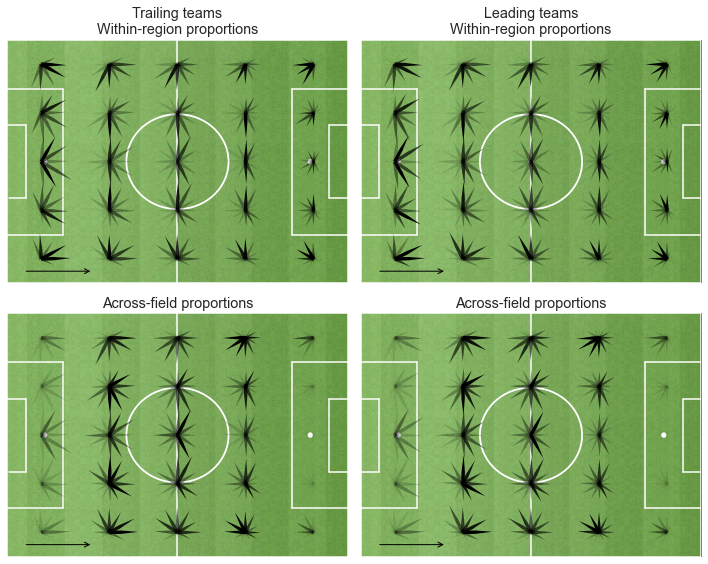

In [25]:
pass_types=[83,85]
n=6
cmap = 'Fade'

args = [n,pass_types]

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2,figsize=(10,8))
pitch(ax0,'white', grass=True, axis=False)
pitch(ax1,'white', grass=True, axis=False)
pitch(ax2,'white', grass=True, axis=False)
pitch(ax3,'white', grass=True, axis=False)

x_vec1, y_vec1, grid1, pcts1, counts1 = radial_vector_field(df_passes_trailing, *args)
x_vec2, y_vec2, grid2, pcts2, counts2 = radial_vector_field(df_passes_leading, *args)

p_args ={'cmap':cmap,
         'width': 0.01,
         'headwidth':1,
         'zorder':100}

for i in range(12):
    ax0.quiver(grid1, grid1, x_vec1[i,:,:], y_vec1[i,:,:], pcts1[i,:,:], **p_args)
    ax1.quiver(grid2, grid2, x_vec2[i,:,:], y_vec2[i,:,:], pcts2[i,:,:], **p_args)
    ax2.quiver(grid1, grid1, x_vec1[i,:,:], y_vec1[i,:,:], counts1[i,:,:]/counts1.sum(), **p_args)
    ax3.quiver(grid2, grid2, x_vec2[i,:,:], y_vec2[i,:,:], counts2[i,:,:]/counts2.sum(), **p_args)

ax0.set_title('Trailing teams\nWithin-region proportions', size='large')
ax1.set_title('Leading teams\nWithin-region proportions', size='large')
ax2.set_title('Across-field proportions', size='large')
ax3.set_title('Across-field proportions', size='large')

fig.tight_layout()
plt.show()

As before, a close inspection will identify changes in the radial vector plots in the different scenarios. In order to better show the changes, we again show the differences for each of the trailing and leading teams relative to the tied scorelines. Here we use a blue to red heat colormap we defined earlier, where blue arrows show decreases in the proportion of passes and red arrows show increases, while smaller changes are made more transparent (forgive the color clashing).

Here we are specifically focusing on the changes in pass proportions, instead of any change pass lengths. Therefore we have left the pass lengths (i.e. the arrow lengths) the same as in the previous plots.

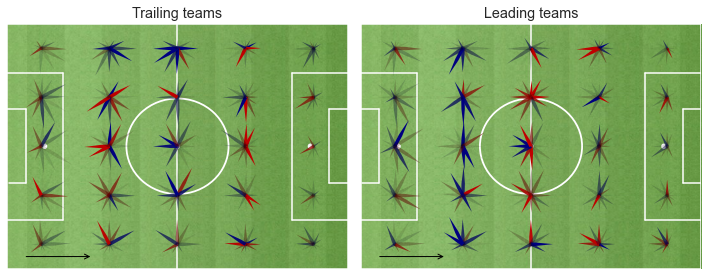

In [26]:
pass_types=[83,85]
n=6
p_args['cmap'] = 'RdBuFade'

args = [n,pass_types]

fig, ax = plt.subplots(1,2,figsize=(10,4))
pitch(ax[0],'white', grass=True, axis=False)
pitch(ax[1],'white', grass=True, axis=False)

x_vec3, y_vec3, grid3, pcts3, counts3 = radial_vector_field(df_passes_base, *args)

for i in range(12):
    ax[0].quiver(grid1, grid1, x_vec1[i,:,:], y_vec1[i,:,:], counts1[i,:,:]/counts1.sum()-counts3[i,:,:]/counts3.sum(), **p_args)
ax[0].set_title('Trailing teams', size='large')
    
for i in range(12):
    ax[1].quiver(grid2, grid2, x_vec2[i,:,:], y_vec2[i,:,:], counts2[i,:,:]/counts2.sum()-counts3[i,:,:]/counts3.sum(), **p_args)
ax[1].set_title('Leading teams', size='large')

fig.tight_layout()
plt.show()

The differences in the two plots are most prominent in the attacking half. Here we see significant increases in forward passes for the trailing team. For the leading team on the other hand we see some increases in backwards passes and increases in lateral passes once the team has reached the middle of the field.

## Next steps

Overall this has turned out to be an interesting exploration into mapping out/exploring the passing patterns of teams. The results of our analyses generally confirmed and demonstrated the changes in patterns of play for teams that are trailing and leading in games. 

Following on from the analyses performed here I would like to explore applying some of these methods of passing analysis in other contexts. For example, comparing passing vector fields between possession oriented teams and more counter-attack oriented teams. There are still some other ideas I would like to explore in relation to the "chasing the game" concept as well which are discussed further in my previous notebook.

Thanks for reading and please feel free to reach out with any suggestions or questions.